In [1]:
!pip install langdetect

from google.colab import files

uploaded = files.upload()

     |████████████████████████████████| 981 kB 8.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=83f9d4a182445401b72d93ccc00a4d6db723f1c0fcdf78137820eeb0112796bf
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


Saving songs_w_lyrics.json to songs_w_lyrics.json


In [2]:
import json, langdetect
import pandas as pd

with open('songs_w_lyrics.json', 'r') as f: 
    songs = json.load(f)

In [3]:
song_lens = {}
max_len = -1
y = []
X = []
songs_combined = {}

for g in songs:
    if g == 'Rock':
        songs_combined['Rock/Pop'] = songs[g]
    elif g == 'Pop':  
        songs_combined['Rock/Pop'] += songs[g]
    else:
        songs_combined[g] = songs[g]


In [4]:
import copy

songs = copy.deepcopy(songs_combined)

In [5]:
for g in songs:
    for t in songs[g]:
        lang = langdetect.detect(t[2].strip()) 
        if (lang != 'en'):
            songs[g].remove(t)
            continue

for g in songs:
    if len(songs[g]) > max_len:
        max_len = len(songs[g])
    song_lens[g] = len(songs[g])
    
for g in songs:
    c = 0
    while (len(songs[g]) != max_len):
        if (c == song_lens[g]):
            c = 0
        songs[g].append(songs[g][c])
        c += 1

songs_combined = None

for g in songs:
    print(len(songs[g]))

1730
1730
1730
1730
1730
1730
1730
1730


In [6]:
import pandas as pd

data = {'artist': [], 'song': [], 'lyrics': [], 'genre': []}

for g in songs:
    for (s, a, l) in songs[g]:
        data['artist'].append(a)
        data['song'].append(s)
        
        data['lyrics'].append(l)
        data['genre'].append(g)

df = pd.DataFrame.from_dict(data)

In [7]:
df['genre'].value_counts()


R&B                   1730
Dance/Electronic      1730
Metal                 1730
Rock/Pop              1730
Folk & Acoustic       1730
Hip-Hop               1730
Country               1730
Christian & Gospel    1730
Name: genre, dtype: int64

In [12]:
import re, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean(text):
    text = text.lower()
    text.replace('\n', ' ')
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub(' ', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df['lyrics'] = df['lyrics'].apply(clean)

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# The maximum number of words to be used.
MAX_NB_WORDS = 50000

# Max number of words in each song.
MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['lyrics'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 38113 unique tokens.


In [15]:
X = tokenizer.texts_to_sequences(df['lyrics'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (13840, 250)


In [16]:
Y = pd.get_dummies(df['genre']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (13840, 8)


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11764, 250) (11764, 8)
(2076, 250) (2076, 8)


In [18]:
from keras import Sequential
from keras.layers import Dense, SpatialDropout1D, LSTM, Embedding

In [19]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 4
batch_size = 64

In [20]:
from keras.callbacks import EarlyStopping

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/4
166/166 [==============================] - 120s 702ms/step - loss: 1.8815 - accuracy: 0.2989 - val_loss: 1.6220 - val_accuracy: 0.4359
Epoch 2/4
166/166 [==============================] - 118s 710ms/step - loss: 1.1912 - accuracy: 0.5962 - val_loss: 1.1147 - val_accuracy: 0.6321
Epoch 3/4
166/166 [==============================] - 118s 712ms/step - loss: 0.7482 - accuracy: 0.7550 - val_loss: 0.9398 - val_accuracy: 0.7145
Epoch 4/4
166/166 [==============================] - 118s 714ms/step - loss: 0.4871 - accuracy: 0.8478 - val_loss: 0.9318 - val_accuracy: 0.7264


In [21]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

65/65 [==============================] - 5s 69ms/step - loss: 0.8636 - accuracy: 0.7327
Test set
  Loss: 0.864
  Accuracy: 0.733


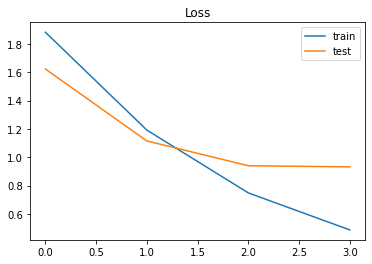

In [22]:
from matplotlib import pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

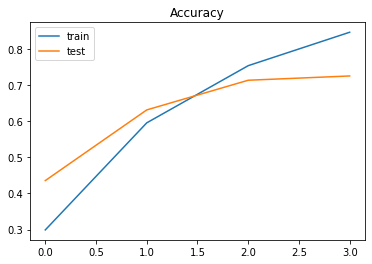

In [23]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();